# **Machine Learning Mode - AdventureWorks**

The objective is to <mark>**forecast the likelihood that a customer or client will make a purchase**</mark> by leveraging statistical records and various influencing factors. This involves analyzing historical data, identifying patterns, and utilizing predictive modeling techniques to assess the probability of future transactions. By incorporating demographic information, purchasing history, behavioral data, and other relevant variables, we aim to create a comprehensive predictive model that can accurately estimate the propensity of a customer or client to buy a product or service. This process not only **enhances targeted marketing** strategies but also improves overall business decision-making by anticipating customer needs and preferences.


### **Importing Data from DataWarehouse**

In [85]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 87, Finished, Available)

In [86]:
# Welcome to your new notebook
# Type here in the cell editor to add code!


abfss_path = "abfss://AdventureGroup@onelake.dfs.fabric.microsoft.com/A00_WH_AdventureGroup.Datawarehouse/Tables/dbo/vTargetMail"
df = spark.read.format("delta").load(abfss_path)
display(df.limit(5))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 88, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4e0dd997-5b23-4a27-9058-9b7ef90b216a)

### **Exploratory Data Analysis (EDA)**

In [87]:
df_summary = df.summary()
display(df_summary)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 89, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7dbbd783-59c1-4963-b425-0708b981e6ac)

In [88]:
print("Total rows: ", df.count())
print ("Total columns: ", len(df.columns))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 90, Finished, Available)

Total rows:  18484
Total columns:  32


In [89]:
from pyspark.ml.feature import StringIndexer


input_cols = ["MaritalStatus","Gender","EnglishOccupation"]
output_cols = ["MaritalStatusIndex","GenderIndex","EnglishOccupationIndex"]


indexer = StringIndexer(inputCols=input_cols, outputCols=output_cols)
df = indexer.fit(df).transform(df)

display(df)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 91, Finished, Available)

SynapseWidget(Synapse.DataFrame, f298ff03-c200-4be3-8abe-0c2579e2f0e3)

In [90]:
df_educList = df.select("EnglishEducation").distinct()
df_educList.show()


df_MilesCommute = df.select("CommuteDistance").distinct()
df_MilesCommute.show()


StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 92, Finished, Available)

+-------------------+
|   EnglishEducation|
+-------------------+
|        High School|
|Partial High School|
|    Graduate Degree|
|    Partial College|
|          Bachelors|
+-------------------+

+---------------+
|CommuteDistance|
+---------------+
|      0-1 Miles|
|      10+ Miles|
|      2-5 Miles|
|     5-10 Miles|
|      1-2 Miles|
+---------------+



In [91]:
list_EnglishEducation =  [
    'Partial High School',
    'High School',
    'Partial College',
    'Graduate Degree',
    'Bachelors',
    'Masters'
]


list_CommuteDistance = [
    '0-1 Miles',
    '1-2 Miles',
    '2-5 Miles',
    '5-10 Miles',
    '10+ Miles'
]

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 93, Finished, Available)

In [92]:
def getIndex(value,myList) :
    index = myList.index(value)
    return index

#RegisterUDF
getIndexmap = udf(getIndex,IntegerType())

df_nominal = df.withColumn("EnglishEducation",getIndexmap(col("EnglishEducation"),lit(list_EnglishEducation)))\
                .withColumn("CommuteDistance",getIndexmap(col("CommuteDistance"),lit(list_CommuteDistance)))
display(df_nominal)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 94, Finished, Available)

SynapseWidget(Synapse.DataFrame, bbd55b2f-3c3f-445f-bbb3-2df722c1c5ee)

In [93]:
df_nominal = df_nominal.drop(*
                    ['CustomerKey',
                    'CustomerAlternateKey',
                    'Title','FirstName',
                    'MiddleName',
                    'LastName',
                    'NameStyle',
                    'BirthDate',
                    'Suffix',
                    'EmailAddress',
                    'SpanishEducation',
                    'FrenchEducation',
                    'SpanishOccupation',
                    'FrenchOccupation',
                    'AddressLine1',
                    'AddressLine2',
                    'Phone',
                    'DateFirstPurchase',
                    'Region',
                    'MaritalStatus',
                    'Gender',
                    'EnglishOccupation'])
display(df_nominal)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 95, Finished, Available)

SynapseWidget(Synapse.DataFrame, 89b8267f-8da8-4fda-9fd4-0ba2a4d22292)

In [94]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=df_nominal.columns,outputCol="VectorData")
df_vector = assembler.transform(df_nominal)
df_vector = df_vector.select('VectorData')
df_vector

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 96, Finished, Available)

DataFrame[VectorData: vector]

In [95]:
matrix = Correlation.corr(df_vector,"VectorData").collect()[0][0]
corr_matrix = matrix.toArray().round(2)
column_names = df_nominal.columns
df_corr = spark.createDataFrame(corr_matrix,column_names)
df_corr_round = df_corr.select(*[round(c, 2).alias(c) for c in column_names])
display(df_corr_round)


StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 97, Finished, Available)

SynapseWidget(Synapse.DataFrame, aae15ed6-766b-4bb2-952d-6ff5d626a0b0)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 98, Finished, Available)

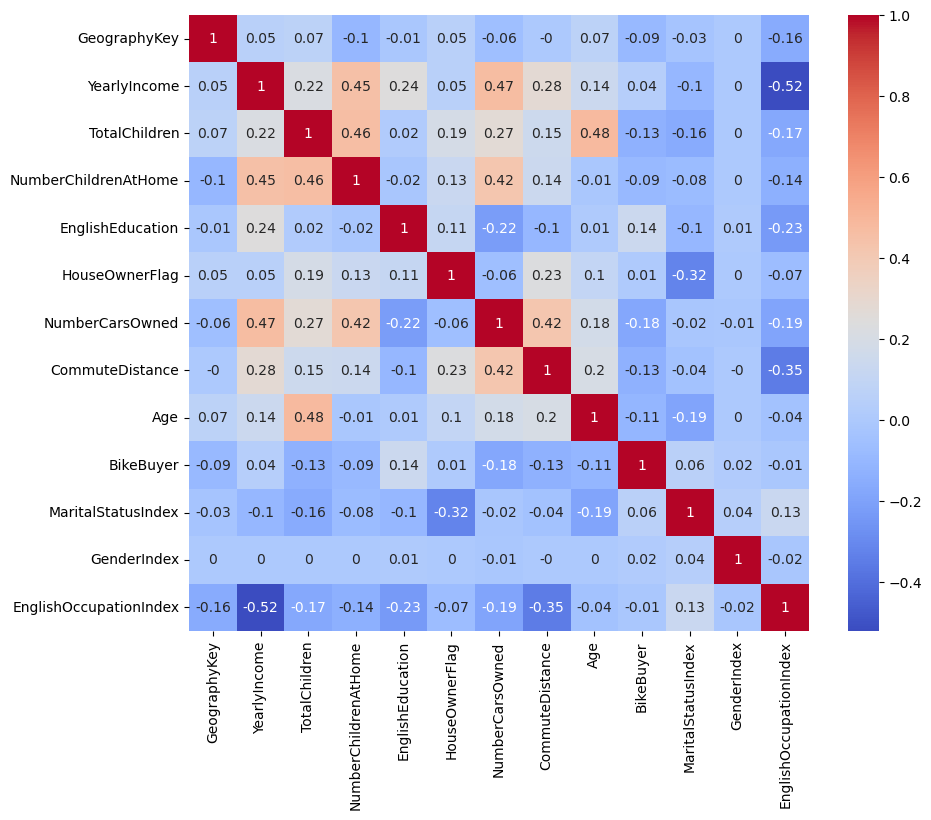

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
plot = sns.heatmap(corr_matrix,annot=True,xticklabels=column_names,yticklabels=column_names,cmap="coolwarm")



In [97]:
df_nominal.printSchema()

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 99, Finished, Available)

root
 |-- GeographyKey: long (nullable = true)
 |-- YearlyIncome: long (nullable = true)
 |-- TotalChildren: long (nullable = true)
 |-- NumberChildrenAtHome: long (nullable = true)
 |-- EnglishEducation: integer (nullable = true)
 |-- HouseOwnerFlag: long (nullable = true)
 |-- NumberCarsOwned: long (nullable = true)
 |-- CommuteDistance: integer (nullable = true)
 |-- Age: long (nullable = true)
 |-- BikeBuyer: long (nullable = true)
 |-- MaritalStatusIndex: double (nullable = false)
 |-- GenderIndex: double (nullable = false)
 |-- EnglishOccupationIndex: double (nullable = false)



In [98]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="VectorData",outputCol="features",withMean=True,withStd=True)
scaler_model = scaler.fit(df_vector)
scaled_data = scaler_model.transform(df_vector)

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 100, Finished, Available)

In [99]:
#X = df_nominal.select(*['TotalChildren','NumberCarsOwned','EnglishEducation','CommuteDistance','Age'])
X = df_nominal.drop(*["BikeBuyer"])
columnNames = X.columns

for i in columnNames :
    mean = df_nominal.select(avg(col(i)).alias('mean')).collect()[0][0]
    std = df_nominal.select(stddev(col(i)).alias('std')).collect()[0][0]
    df_nominal = df_nominal.withColumn(i,round((col(i)-mean)/std,2))

display(df_nominal.limit(5))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 101, Finished, Available)

SynapseWidget(Synapse.DataFrame, 22511379-047f-474d-8206-d3b61ec4d1ed)

In [100]:
assembler = VectorAssembler(inputCols=columnNames,outputCol="features")
df_vector = assembler.transform(df_nominal)
df = df_vector.select('features','BikeBuyer')

display(df.limit(5))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 102, Finished, Available)

SynapseWidget(Synapse.DataFrame, b2a5f309-79b3-4d7b-8e71-f60c83faed79)

### **Training the model**

In [101]:
# Split the data by test and train dataset
train_data,test_data = df.randomSplit([0.8,0.2],seed=42)
display(train_data.limit(5))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 103, Finished, Available)

SynapseWidget(Synapse.DataFrame, 24f0a24d-3df4-47d2-ae3b-89edcf16442d)

In [102]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol="features",labelCol="BikeBuyer",maxIter=3)
df = lr.fit(train_data)

preds = df.transform(test_data)
display(preds.limit(5))

auc = BinaryClassificationEvaluator().setLabelCol("BikeBuyer")
print(str(auc.evaluate(preds)))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 104, Finished, Available)

SynapseWidget(Synapse.DataFrame, bfc613f6-071f-4dc2-970b-9069e797f657)

0.6737617120618796


In [103]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features",labelCol="BikeBuyer",numTrees=20,maxDepth=30,seed=42)
df_rf = rf.fit(train_data)

pred_rf = df_rf.transform(test_data)
display(pred_rf.limit(5))

rf_auc = BinaryClassificationEvaluator().setLabelCol("BikeBuyer")
print(str(rf_auc.evaluate(pred_rf)))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 105, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4547913a-cdd8-4518-a639-41475654627e)

0.8833550985762685


In [104]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features",labelCol="BikeBuyer",maxIter=50,maxDepth=10,seed=42)
df_gbt = gbt.fit(train_data)

pred_gbt = df_gbt.transform(test_data)
display(pred_gbt.limit(5))

gbt_auc = BinaryClassificationEvaluator().setLabelCol("BikeBuyer")
print(str(gbt_auc.evaluate(pred_gbt)))

StatementMeta(, 6f073a23-75b4-4a7e-850b-0d51da56a703, 106, Finished, Available)

SynapseWidget(Synapse.DataFrame, a4aee060-2b9c-4b22-8d4a-6ef67067ecc9)

0.8731458676915412
